# Age structured SIR model for the UK with social distancing

Here, we continue the excellent work conducted by Rajesh Singh and R Adhikari to extend a deterministic SIR model using UK data. We use the $\beta$ parameter obtained with communications with Rajesh Singh to visualise what would happen to the number of Covid-19 cases in the UK once lockdown measures are enforced. Note these simulations are for an idealised, best case scenario where as soon as lockdown measures are implemented, we see a drop in the number of cases.

Please note that this exercise is simply for our educational purposes and we understand that this is in no way, a comprehensive model or study to effectively predict the number of Covid-19 cases in the UK. Here, we have only taken March case data and used to create projections on the number of infected individuals.

In this model, we assume that the lag that occurs once a lockdown is implemented, is less than a day. In other words, we assume the lockdown acts instantenously. Please note that all credit goes to Rajesh Singh and R Adhikari, we have simply used their code to point towards the UK data and run simulations. More information around the technical details of their model, as well as their excellent paper, can be found here:

    - https://github.com/rajeshrinet/pyross
    - https://arxiv.org/abs/2003.12055

# Initial Config

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  ## mortality per 100

In [3]:
## population and age classes
M=14  ## number of age classes

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

# UK case data

In [5]:
import urllib.request, json

#GET JSON FILE
#Open the JSON file
with urllib.request.urlopen('https://opendata.ecdc.europa.eu/covid19/casedistribution/json/') as url:
    data = json.loads(url.read().decode('utf-8-sig'))

#Make a list of nested dictionaries
data = data['records']

#Put into dataframe
df = pd.DataFrame(data)

df['dateRep'] = pd.to_datetime(df['dateRep'], format='%d/%m/%Y')

#We will isolate a dataframe containing data only for the UK
df_uk = df.loc[df['countriesAndTerritories'] == 'United_Kingdom']

#We make a dataframe for the only the UK cases in order to complete analysis
df_cases_uk = df_uk[['dateRep', 'cases']]
df_cases_uk = df_cases_uk.astype({'cases': 'float64'})

df_cases_uk = df_cases_uk[(df_cases_uk['dateRep']>'2020-02-29') & (df_cases_uk['dateRep']<'2020-04-01')].sort_values(by='dateRep')

# One closure

In [6]:
beta  = 0.02646691      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# the contact matrix is time-dependent
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=98.5;  Nf=2000 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

Text(0.5, 1.0, 'Prediction of Covid-19 cases in the UK with one closure')

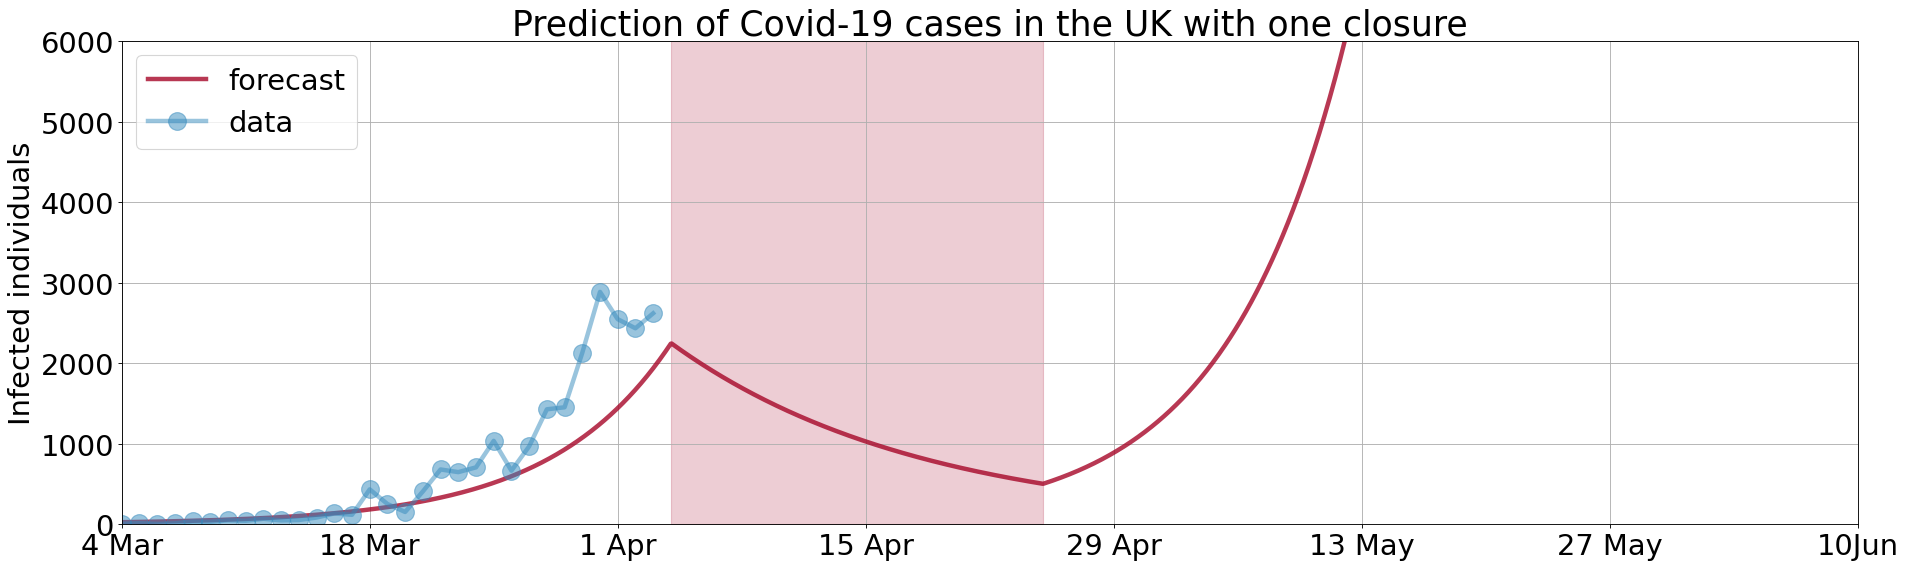

In [7]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));
t1=int(Nf/14)

plt.fill_between([31,52], 0, 6000, color="#A60628", alpha=0.2)

day, cases = df_cases_uk['dateRep'].to_numpy(), df_cases_uk['cases'].to_numpy()

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 6000); plt.xlim(0, 98);
plt.title('Prediction of Covid-19 cases in the UK with one closure')

# Two closures

In [8]:
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    elif 52<=t<57:
        xx = C
    elif 57<=t<85:
        xx = CH
    else:
        xx = C
    return xx

# start simulation
Tf=98;  Nf=2000 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

Text(0.5, 1.0, 'Prediction of Covid-19 cases in the UK with two closures')

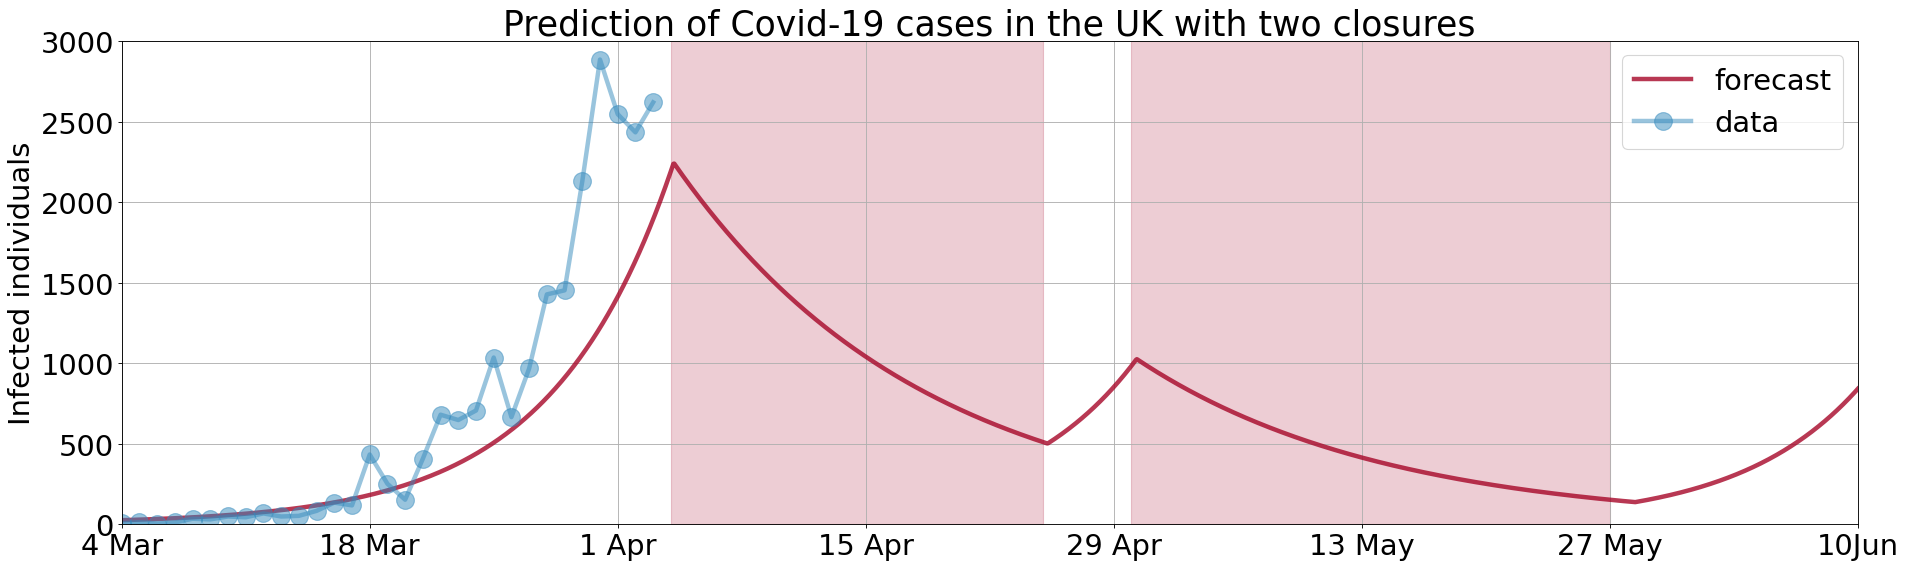

In [9]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))

plt.fill_between([31,52], 0, 3000, color="#A60628", alpha=0.2)
plt.fill_between([57,84], 0, 3000, color="#A60628", alpha=0.2)

day, cases = df_cases_uk['dateRep'].to_numpy(), df_cases_uk['cases'].to_numpy()

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 3000);
plt.title('Prediction of Covid-19 cases in the UK with two closures')

# Three closures

In [10]:
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    elif 52<=t<57:
        xx = C
    elif 57<=t<85:
        xx = CH
    elif 85<=t<70:
        xx = C
    else:
        xx = CH
    return xx


# start simulation
Tf=98;  Nf=2000;  
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

Text(0.5, 1.0, 'Prediction of Covid-19 cases in the UK with three closures')

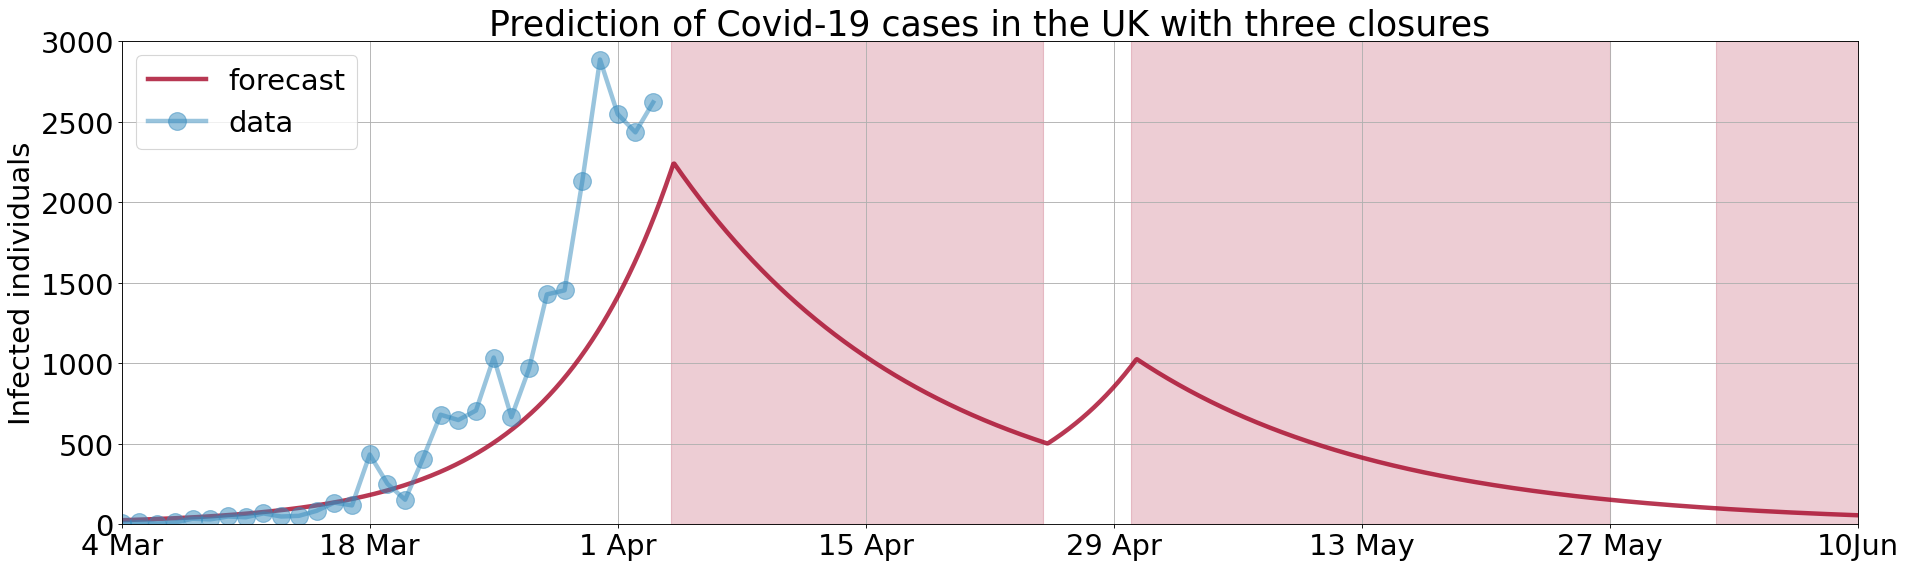

In [11]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))
plt.fill_between([31,52], 0, 3000, color="#A60628", alpha=0.2)
plt.fill_between([57,84], 0, 3000, color="#A60628", alpha=0.2)
plt.fill_between([90,100], 0, 3000, color="#A60628", alpha=0.2)


day, cases = df_cases_uk['dateRep'].to_numpy(), df_cases_uk['cases'].to_numpy()

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 3000);
plt.title('Prediction of Covid-19 cases in the UK with three closures')

# One long closure

In [12]:
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<80:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=84;  Nf=2000;  
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

Text(0.5, 1.0, 'Prediction of Covid-19 cases in the UK with one long closure')

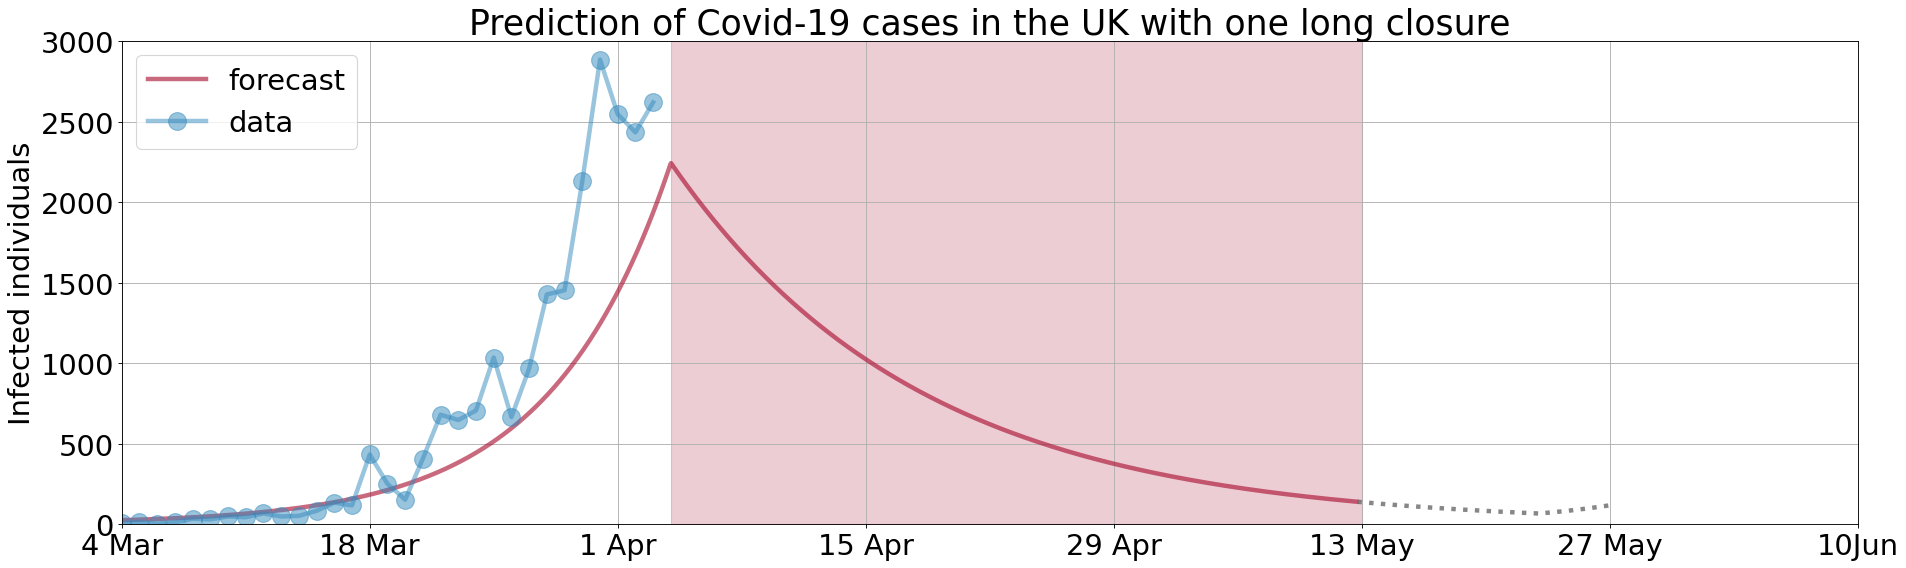

In [13]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

t = data['t']; t1=int(Nf/(12))
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t[0:10*t1], IC[0:10*t1], '-', lw=4, color='#A60628', label='forecast', alpha=0.6)

plt.plot(t[10*t1:], IC[10*t1:], ':', lw=4, color='dimgrey', alpha=0.8)

plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

plt.fill_between([31,70], 0, 3000, color="#A60628", alpha=0.2)

day, cases = df_cases_uk['dateRep'].to_numpy(), df_cases_uk['cases'].to_numpy()

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 3000); plt.xlim(0, 98);
plt.title('Prediction of Covid-19 cases in the UK with one long closure')
#IC[-1]

As with the results for India obtained by R.Singh and R.Adhikari, we find that one 21 day lockdown is insufficient in controlling the number of infected individuals in the UK. In this scenario, we may see a decrease in the number of cases during this time but once this lockdown ends, we see an increase in the number of cases once again.

We find, that a series of lockdowns are needed in order to effectively reduce the number of cases in the UK. These need not be back to back and we find that a small gap between lockdowns is possible to implement. Although the number of cases may increase during this time, it will not be enough to overwhelm the NHS.